In [2]:
import os
import time
import urllib2
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib.backends.backend_pdf import PdfPages
from math import sqrt
from itertools import chain
from astropy.io import fits
from astropy.coordinates import SkyCoord
from queries import Mast, Simbad
from IPython.display import clear_output,Image, display
import pickle

%matplotlib inline
plt.style.use('fivethirtyeight')

top_path='/DataDisk/datafiles/PGCC_HST/'
#top_path='/Users/codydirks/PGCC/'

#Returns angular separation between two Ra/Dec coordinates in degrees
def get_ang_sep(ra1,dec1,ra2,dec2):
    ra1_rad=ra1*np.pi/180.
    dec1_rad=dec1*np.pi/180.
    ra2_rad=ra2*np.pi/180.
    dec2_rad=dec2*np.pi/180.

    del_ra=ra2_rad-ra1_rad
    del_ras=np.sin(del_ra)
    del_rac=np.cos(del_ra)
    dec1s=np.sin(dec1_rad)
    dec2s=np.sin(dec2_rad)
    dec1c=np.cos(dec1_rad)
    dec2c=np.cos(dec2_rad)
    result=(180./np.pi)*np.arctan(np.sqrt((dec2c**2)*(del_ras**2)+(dec1c*dec2s-dec1s*dec2c*del_rac)**2)/(dec1s*dec2s+dec1c*dec2c*del_rac))
    if result < 0:
        return result+180.
    else:
        return result
    
def get_r_dist(pgcc,sightline_ra,sightline_dec):
    angle=pgcc['gau_position_angle']
    sin=np.sin(-angle)
    cos=np.cos(-angle)
    a=pgcc['gau_major_axis']/2.
    b=pgcc['gau_minor_axis']/2.
    gal=SkyCoord(ra=sightline_ra*u.degree,dec=sightline_dec*u.degree,frame='icrs').galactic
    del_l=60.*(gal.l.value-pgcc['glon'])
    del_b=60.*(gal.b.value-pgcc['glat'])
    return np.sqrt((((cos*del_l+sin*del_b)/a)**2+((sin*del_l-cos*del_b)/b)**2))

In [2]:
#Grab all STIS echelle results - better to grab everything once than query repeatedly
gratings=['E140H']#('E140H','E140M','E230H','E230M')
stis_results=list(chain(*[Mast.STISSearch(grating=x) for x in gratings]))

In [38]:
targs=list(set([x.target for x in stis_results]))
hds=[x for x in targs if x.startswith('HD')]
print len(hds)
for targ in [x for x in targs if x.startswith('HD')==False]:
    if targ.startswith('BD'):
        if targ[5]=='D':
            targ=targ[0:5]+' '+targ[6:]
    elif targ.startswith('CPD'):
        if targ[6]=='D':
            targ=targ[0:6]+' '+targ[7:]
    else:
        targ=targ.replace('-',' ')
    if targ.startswith('V '):
        targ=targ[2:]
    try:
        idlist=Simbad.IDList(targ)
        hd=[x for x in idlist if x.startswith('HD')]
        if len(hd)==1:
            hds.append(hd[0])
        #print targ, hd
    except:
        #print '\t\t\t\t',targ
        pass

cleaned_hds=[]
for hd in hds:
    cleaned_hd=hd
    if hd[2]=='-':
        cleaned_hd=hd[0:2]+hd[3:]
    cleaned_hd=cleaned_hd.split('-')[0]
    cleaned_hd=cleaned_hd.replace(' ','')
    cleaned_hds.append(cleaned_hd)

231


In [41]:
# Grab all the raw '_x1d.fits' datasets in my current sample
# Can check against this to make sure a dataset is actually 'new'
path=top_path+'x1d_files/'
datasets=[]
for root,dirs,files in os.walk(path):
    for fl in files:
        if fl.endswith('_x1d.fits'):
            datasets.append(fl[:-len('_x1d.fits')].upper())
            
current_hds=[x for x in os.listdir(path) if os.path.isdir(path+x) and x.startswith('.')==False]
cleaned_hds=[x for x in cleaned_hds if x not in current_hds]

In [4]:
# Isolate datasets with an obs date after the latest one in my current sample (2014-11-06)
new_datasets=[]
for res in stis_results:
    year,month,day=[int (i) for i in res.date.split('-')]
    if year >=2014 and month >= 11 and day > 6:
        new_datasets.append(res)

In [43]:
hdulist=fits.open(top_path+'HFI_PCCS_GCC_R2.02.fits')
p_file='new_stis_datasets.p'
pgcc_data=hdulist[1].data
i=0
results=[]
sigma=10.

results=[]
for hd in cleaned_hds:
    coords=Simbad.Position(hd)
    ra=coords[0].value
    dec=coords[1].value
    nearest=10000.
    nearest_pgcc=[]
    for pgcc in pgcc_data:
        pgcc_ra=pgcc[3]
        pgcc_dec=pgcc[4]
        if abs(pgcc_ra-ra)<30 and abs(pgcc_dec-dec)<30:
            ang_sep=get_ang_sep(ra,dec,pgcc_ra,pgcc_dec)
            if ang_sep<nearest:
                nearest=ang_sep
                nearest_pgcc=pgcc
    r_dist=get_r_dist(nearest_pgcc,ra,dec)
    if r_dist < sigma:
        print hd, r_dist
        results.append(((hd,coords),nearest_pgcc))

print
print len(results)
pickle.dump(results,open(p_file,'wb'))

HD104705 7.66957095427


/home/cody/python/lib/python2.7/site-packages/ipykernel/__main__.py:52: RuntimeWarning: divide by zero encountered in double_scalars


HD75309 9.21347646486
HD148594 7.60356897454
HD202347 6.21939067304
HD10250 7.55704115709
HD207198 7.6935225908
HD191877 9.29919626664
HD52266 5.90549318677
HD43582 3.31118091413
HD128621 2.50248916411
HD282624 1.98485964147
HD108639 4.5536970242
HD185418 7.26614765318
HD177989 6.04028304554
HD117111 7.52334481095
HD128621 2.50248916411
HD128621 2.50248916411
HD93237 8.66747073069
HD37061 4.35848577497
HD50138 6.80753520977
HD112999 7.71239638861
HD108927 8.17571287869
HD283654 1.6702017144
HD128620 2.48284678971
HD25443 6.40116267345
HD23478 6.12563917043
HD210839 9.05020541083
HD23873 8.05212306687
HD52329 5.97911897445
HD165918 5.0127810062
HD157857 7.89145851878
HD432 4.41302565027
HD254755 5.43663029868
HD32630 7.66153435721
HD94493 9.40622515208
HD040893 4.23653991408
HD24398 9.09929242818
HD14818 8.9506821669
HD152424 8.24859189937
HD99857 7.01794269309
HD209339 9.04074680647
HD218915 9.75890160432
HD152590 6.77267743673
HD115455 8.64057148423
HD51285 6.85734907489
HD106943 6.55

In [44]:
results=pickle.load(open(p_file,'rb'))
print len(results)

54


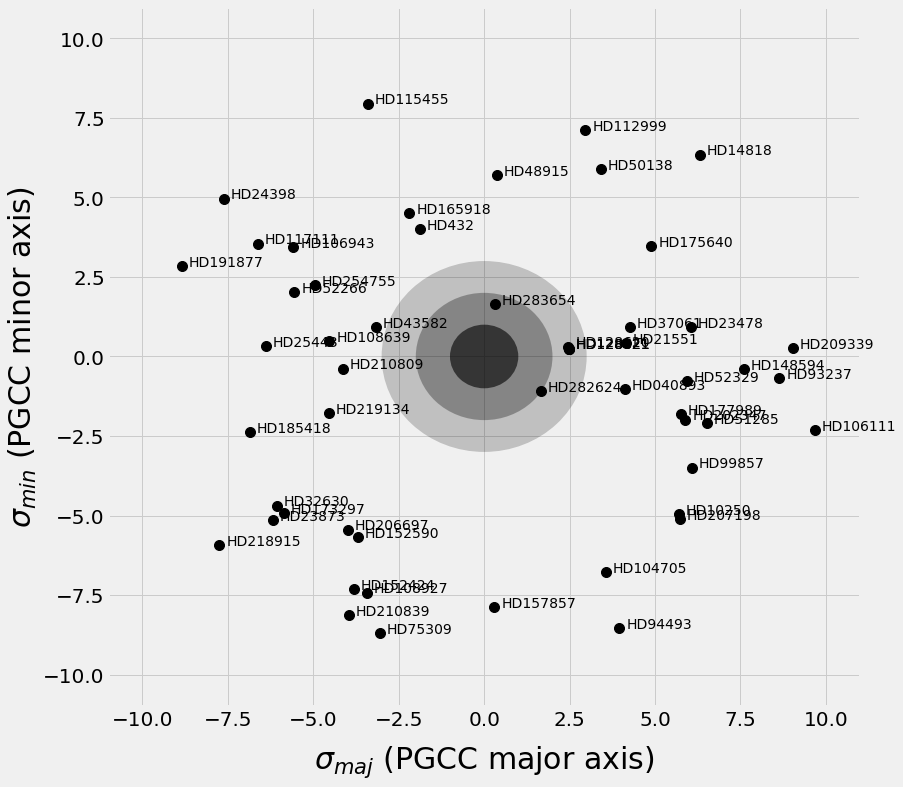

In [46]:
fig=plt.figure(1,figsize=(12,12))
subplt=plt.subplot(111)


subplt.set_xlim(-11,11)
subplt.set_ylim(-11,11)
subplt.set_xlabel('$\sigma_{maj}$ (PGCC major axis)',fontsize=30,labelpad=15)
subplt.set_ylabel('$\sigma_{min}$ (PGCC minor axis)',fontsize=30)
subplt.tick_params(axis='x',labelsize=20)
subplt.tick_params(axis='y',labelsize=20)
for i in range(1,4):
    ell=Ellipse(xy=(0,0),width=2*i,
                height=2*i
                ,angle=0)
    ell.set_facecolor('k')
    ell.set_alpha(0.6/i)
    subplt.add_patch(ell)
        
for pair in results:
    sightline=pair[0][0]
    pgcc=pair[1]
    r_dist=get_r_dist(pgcc,pair[0][1][0].value,pair[0][1][1].value)
    if r_dist<10:
        ra,dec=pair[0][1]
        galcoord=SkyCoord(ra=ra,dec=dec).galactic
        del_l=60.*(galcoord.l.value-pgcc['glon'])
        del_b=60.*(galcoord.b.value-pgcc['glat'])
        theta=np.arctan(del_b/del_l)
        omega=-pgcc['gau_position_angle']
        phi=theta-omega
        sig_x=r_dist*np.cos(phi)
        sig_y=r_dist*np.sin(phi)
        if del_l<0:
            sig_x=-sig_x
            sig_y=-sig_y

        col='k'
        subplt.plot(sig_x,sig_y,marker='o',color=col,ms=10,mec=col)
        subplt.text(sig_x+0.2,sig_y,sightline)

O8NA02010, O8NA02020, OBKR55010, O57R01010, O6LJ07020, O6LJ0A020, OBKR7V010, O6LJ0C010, O6LJ0C020, O6LJ0F010, O6LJ0F020, OBKR3T010, OBKR7F010, O5C04A010, OBKR6H010, O5C08P010, O8NA04010, O8NA04020, O5C04D010, OBKR4D010, OCB6Q1020, OCB6Q0020, O57R03010, O57R03020, O5C01Q010, OBKR1Q010, OBIE08010, O5G301010, O59S06010, O59S06020, O5LH0B020, O5LH0B010, O5C01V010, OBKR1V010, O54304010, OBKR03010, O57R05010, O6LJ01020, O5C02F010, O64810020, O64810010, O64811020, O64811010, OBKR7G010, OB2303010, O59S03010, OBKR2X010, OBKR26010, O5C027010, O5C07L010, O5C05B010, O6LJ0G020, O54306010, O54301030, O54301020, O54301010,


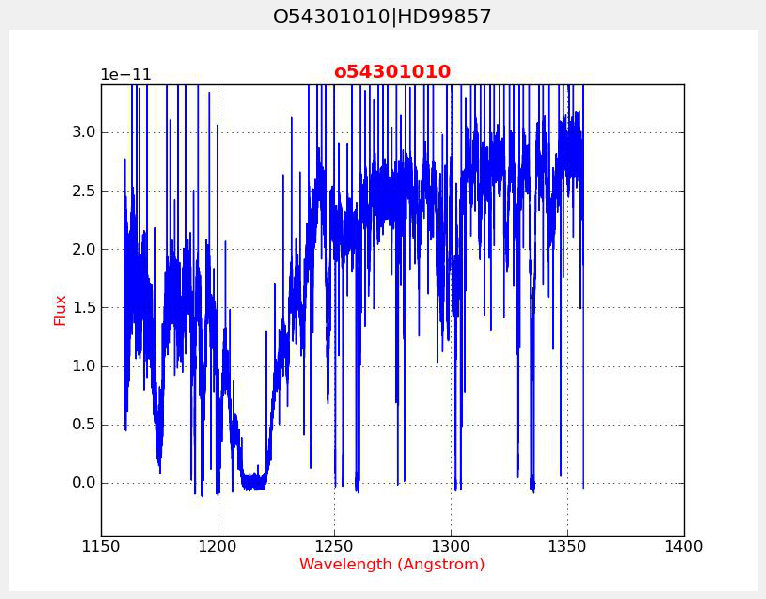

In [68]:
fig=plt.figure(figsize=(12,12))
pdf=PdfPages('new_datasets.pdf')


remove=['HD128620','HD128621','HD282624','HD283654','HD432']
for hd in [x for x in results if x[0][0] not in remove]:
    datasets=Mast.STISSearch(target=hd[0][0],radius=0.5)
    for dataset in [x for x in datasets if x.cenwav-101. < 1347.2396 < x.cenwav+101.]:
        subplt=plt.subplot(111)
        subplt.set_title(dataset)
        subplt.set_xticks([])
        subplt.set_yticks([])
        url='http://archive.stsci.edu/missions/hst/previews/'+dataset.dataset[0:4]+'/'+dataset.dataset+'.jpg'
        try:
            image=urllib2.urlopen(url)
            im=plt.imread(image,format='jpeg')
            subplt.imshow(im)
            pdf.savefig(fig)
            print dataset.dataset+',',
        except:
            pass
pdf.close()

In [4]:
p_file='new_stis_datasets.p'
results=pickle.load(open(p_file,'rb'))

remove=['HD128620','HD128621','HD282624','HD283654','HD432']
for hd in [x for x in results if x[0][0] not in remove]:
    print hd[0][0],
    datasets=Mast.STISSearch(target=hd[0][0],radius=0.5)
    for dataset in [x for x in datasets if x.cenwav-101. < 1347.2396 < x.cenwav+101.]:
        print dataset.dataset,
    print

HD104705 O57R01010
HD75309 O5C05B010
HD148594 O5C04A010
HD202347 O5G301010
HD10250 OBKR55010
HD207198 O59S06010 O59S06020
HD191877 OBIE08010
HD52266 O5C027010
HD43582 OCKI01010 OCKI01020 OCKI01030 OCKI01040 OCKI01050
HD108639 O6LJ0A020
HD185418 O5C01Q010 OBKR1Q010
HD177989 O57R03010 O57R03020
HD117111 OBKR3T010
HD93237 O6LJ0G020
HD37061 O59S03010
HD50138 OBKR2X010
HD112999 O6LJ0C010 O6LJ0C020
HD108927 OBKR7V010
HD25443 OBKR7G010
HD23478 O6LJ01020
HD210839 O54304010
HD23873 O5C02F010
HD52329 O5C07L010
HD165918 OCYL03010 OCYL03020
HD157857 O5C04D010 OBKR4D010
HD254755 OCKI02010 OCKI02020 OCKI02030 OCKI02040 OCKI02050
HD32630 OB2303010
HD94493 O54306010
HD040893 O8NA02010 O8NA02020
HD24398 O64810020 O64810010 O64811020 O64811010
HD14818 OBKR7F010
HD152424 OBKR6H010
HD99857 O54301030 O54301020 O54301010
HD209339 O5LH0B020 O5LH0B010
HD218915 O57R05010
HD152590 O5C08P010 O8NA04010 O8NA04020
HD115455 O6LJ0F010 O6LJ0F020
HD51285 OBKR26010
HD106943 O6LJ07020
HD210809 O5C01V010 OBKR1V010
HD21551